## Load Required Modules

In [1]:
%reload_ext autoreload
%autoreload 2

#Prime the GPU
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
hello = tf.constant('Hello, TensorFlow!')
print(session.run(hello))

import pandas as pd
from DeepText.preprocess import preProcessor_in_memory, presto2df
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

b'Hello, TensorFlow!'


Using TensorFlow backend.


In [8]:
# REMOVE THIS LINE IF YOU ARE GOING TO PUT IN PRODUCTION
df = pd.read_parquet('training_data.parquet')

In [9]:
query = """
SELECT repo_name, repo_id, repo_homepage, issue_id, issue_number, 
        body, 
        issue_title,
        cardinality(split(issue_title, ' ')) as issue_title_len,
        cardinality(split(body, ' ')) as body_len
        
FROM(
SELECT  
   r.name as repo_name
 , r.homepage as repo_homepage
 , i.repository_id as repo_id
 , i.id as issue_id
 , i.number as issue_number
 , substr(trim(regexp_replace(lower(from_utf8(i.body)), '<[^>]*>|[^a-zA-Z_\s]')), 1, 500) as body
 , trim(regexp_replace(lower(from_utf8(i.title)), '<[^>]*>|[^a-zA-Z_\s]')) as issue_title
FROM hive.snapshots_presto.issues as i
JOIN hive.entities.repos as r on 
    i.repository_id = r.repo_id and
    r.num_stars >= 50 and 
    r.num_issues >= 10 and 
    r.num_prs >= 10 and 
    r.num_merged_pr_authors >= 3 and 
    r.num_issue_authors >= 3 and not
    r.is_fork and 
    r.num_fetchers_last_30_days >= 2 and
    r.is_public
WHERE i.body is not null and i.title is not null
) a
WHERE cardinality(split(issue_title, ' ', 5)) = 5 AND cardinality(split(body, ' ', 10)) = 10
limit 1400000
"""

# YOU WANT TO UNCOMMENT THIS LINE WHEN PUTTING IN PRODUCTION.  I JUST CACHED THE RESULTS INSTEAD
#df = presto2df(query)
n_rows, n_columns = df.shape
print(f'There are {n_rows:,} rows and {n_columns} columns in this data.')
data_to_clean_body = df.body.tolist()
data_to_clean_title = df.issue_title.tolist()
df.head()

There are 1,400,000 rows and 9 columns in this data.


,repo_name,repo_id,repo_homepage,issue_id,issue_number,body,issue_title,issue_title_len,body_len
0,mod_pagespeed,33489346,http://modpagespeed.com,66637566,677,entering this on behalf of the user who wishes...,mod_pagespeed causing high load on my server,7,87
1,mod_pagespeed,33489346,http://modpagespeed.com,66637570,678,not able to find the file cacheflush in the sp...,automatically make cacheflush file on install ...,10,29
2,mod_pagespeed,33489346,http://modpagespeed.com,66637575,679,you can still set a location handler for the b...,document new beacon handling logic in next rel...,8,69
3,mod_pagespeed,33489346,http://modpagespeed.com,66637576,680,right now flatten_css_imports requires rewrite...,if flatten_css_imports is enabled without rewr...,11,78
4,mod_pagespeed,33489346,http://modpagespeed.com,66637578,681,what steps will reproduce the problem\n\nin my...,mod_pagespeed dont respect errorlevel settings...,8,75


In [10]:
#UNCOMMENT THIS LINE WHEN YOU PUT INTO PRODUCTION
#df.to_parquet('training_data.parquet', engine='fastparquet', compression='UNCOMPRESSED')

In [11]:
!ls -lah | grep .parquet

-rw-r--r--  1 root  root  604M Dec 13 20:44 training_data.parquet


# Pre-Process Data

### Preview Raw Data

A sample of what the body of an issue looks like

In [12]:
data_to_clean_body[0]

'entering this on behalf of the user who wishes to remain anonymous\n\nwhat steps will reproduce the problem\n turning on mod_pagespeed and browsing the website\n new site on dedicated server there are no other visitors besides me load \naverage is usually  to  turning on mod_pagespeed and browsing a few \npages results in load average going up to  to  if i dont restart apache \nand continue browsing this goes up to  and crashes server\n\nwhat version of the product are you using please check xmodpagespee'

A sample of what the title of that same issue looks like

In [13]:
data_to_clean_title[0]

'mod_pagespeed causing high load on my server'

## Build Word -> Idx Mapping

`ppm.fit_transform` performs the following steps using all threads available:

1.  Cleans each document as using default cleaning function (from textacy) or one that you set.
2.  Tokenizes each document using defualt tokenizer (spacy-english) or one that you set.
3.  Builds a vocabulary of all tokens and builds a mapping from each token -> integer index.  Extremely rare tokens are excluded and an additional place is reserved for new or unseen words.
4.  Applies the token -> integer mapping over all of the documents, and applies padding and truncating to bring each document to a consistent width. 

#### Learn vocabulary from training data

In [14]:
#specifying the huerestic and the maxlen yourself makes this run faster the utility doesn't have to calculate these for you.
ppm_body = preProcessor_in_memory(hueristic_pct=.61, keep_n=6000, maxlen=60)
vectorized_body = ppm_body.fit_transform(data_to_clean_body)

In [15]:
import dill as dpickle

In [16]:
dpickle.dump(ppm_body, open( "ppm_body.dpkl", "wb" ) )

In [17]:
vectorized_body[:1]

array([[ 2,  3,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16, 17,
         7, 18, 19, 20,  4,  1, 21, 22,  7, 23, 19, 24, 25,  4, 26, 27, 28,
        29, 30, 31,  1, 32, 33, 34, 35, 36, 37, 10, 20,  4,  1, 21, 22, 38,
        39, 40, 41, 42, 34, 35, 43, 44, 10]], dtype=int32)

Lets see statistics on document length

In [18]:
vectorized_body[:1]

array([[ 2,  3,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16, 17,
         7, 18, 19, 20,  4,  1, 21, 22,  7, 23, 19, 24, 25,  4, 26, 27, 28,
        29, 30, 31,  1, 32, 33, 34, 35, 36, 37, 10, 20,  4,  1, 21, 22, 38,
        39, 40, 41, 42, 34, 35, 43, 44, 10]], dtype=int32)

#### Compare Vectorized Data To Original

We want to check that these numbers are correct.  How do we do that?  There are dictionaries attached to the `preProcessor_in_memory` class that give idx -> word mappings and word -> index mappings.

In [19]:
data_to_clean_body[:2]

['entering this on behalf of the user who wishes to remain anonymous\n\nwhat steps will reproduce the problem\n turning on mod_pagespeed and browsing the website\n new site on dedicated server there are no other visitors besides me load \naverage is usually  to  turning on mod_pagespeed and browsing a few \npages results in load average going up to  to  if i dont restart apache \nand continue browsing this goes up to  and crashes server\n\nwhat version of the product are you using please check xmodpagespee',
 'not able to find the file cacheflush in the specified at \nmodpagespeedfilecachepath\n\noperating system is linux\napache \nmps version \n\n\n\n\noriginal issue reported on codegooglecom by somanathgmailcom on  apr  at']

Convert Vector back to to text with the following exceptions:

- 0: is just padding
- 1: is reserved for unseen or rare wordds

In [21]:
print('First Example :\n=====\n', [ppm_body.id2token[x] for x in vectorized_body[0] if x > 1])

print('\nSecond Example :\n=====\n', [ppm_body.id2token[x] for x in vectorized_body[1] if x > 1])

First Example :
=====
 ['entering', 'this', 'on', 'behalf', 'of', 'the', 'user', 'who', 'to', 'remain', 'anonymous', '\n', 'what', 'steps', 'will', 'reproduce', 'the', 'problem', '\n ', 'turning', 'on', 'and', 'browsing', 'the', 'website', '\n ', 'new', 'site', 'on', 'dedicated', 'server', 'there', 'are', 'no', 'other', 'besides', 'me', 'load', 'average', 'is', 'usually', 'to', 'turning', 'on', 'and', 'browsing', 'a', 'few', 'pages', 'results', 'in', 'load', 'average', 'going', 'up', 'to']

Second Example :
=====
 ['not', 'able', 'to', 'find', 'the', 'file', 'in', 'the', 'specified', 'at', '\n', 'operating', 'system', 'is', 'linux', '\n', 'apache', 'version', 'original', 'issue', 'reported', 'on', 'codegooglecom', 'by', 'on', 'apr', 'at']


Also for sanity check, lets confirm the most common tokens that the parser found in our text:

In [22]:
ppm_body.token_count_pandas().head()

,count,token
5,1048898,the
11,967821,\n
8,951024,to
36,740399,a
34,683265,is


#### Pre-process Issue Titles

Now that we have created this for an issue body, lets do the same for the issue titles, which will have a seperate integer mapping.  In this case, we want to append <Start> and <End> indicators around the titles so our sequence to sequence model can work properly and let us know when it thinks the issue title should End. 

In [23]:
# %reload_ext autoreload
# %autoreload 2
# from DeepText.preprocess import preProcessor_in_memory
ppm_title = preProcessor_in_memory(hueristic_pct=.99, append_indicators=True, padding='post', keep_n=4000, maxlen=12)
vectorized_title = ppm_title.fit_transform(data_to_clean_title)

In [24]:
dpickle.dump(ppm_title, open( "ppm_title.dpkl", "wb" ) )

In [25]:
ppm_title.token_count_pandas().head()

,count,token
0,1400000,_start_
7,1400000,_end_
63,275175,to
20,204193,in
12,179587,for


As expected the <Start> and <End> indicators are the most common tokens in the title space as they are appended to every title.

Check the shape of the Issue Body and Issue Title numpy arrays:

In [26]:
print(f'shape of issue body array: {vectorized_body.shape}')
print(f'shape of issue title array: {vectorized_title.shape}')

shape of issue body array: (1400000, 60)
shape of issue title array: (1400000, 12)


# Save Data

In [27]:
# Save Arrays
import numpy as np
np.save('body_vectors.npy', vectorized_body)
np.save('title_vectors.npy', vectorized_title)

# Save id <-> token mappings
title_id2token = ppm_title.id2token
title_token2id = ppm_title.token2id
dpickle.dump(title_id2token, open( "title_id2token.dpkl", "wb" ) )
dpickle.dump(title_token2id, open( "title_token2id.dpkl", "wb" ) )

In [28]:
! ls -lah | grep .npy

-rw-r--r--  1 root  root  321M Dec 15 01:14 body_vectors.npy
-rw-r--r--  1 root  root   65M Dec 15 01:14 title_vectors.npy


In [29]:
!ls -lah | grep .dpkl

-rw-r--r--  1 root  root  993M Dec 15 00:35 ppm_body.dpkl
-rw-r--r--  1 root  root  173M Dec 15 01:13 ppm_title.dpkl
-rw-r--r--  1 root  root   76K Dec 15 01:14 title_id2token.dpkl
-rw-r--r--  1 root  root   76K Dec 15 01:14 title_token2id.dpkl


# Load Data (You Can Re-Run From Here)

In [30]:
import numpy as np
vectorized_body = np.load('body_vectors.npy')
vectorized_title = np.load('title_vectors.npy')

In [31]:
import dill as dpickle
with open('ppm_body.dpkl', 'rb') as file:
    ppm_body = dpickle.load(file)
    
with open('ppm_title.dpkl', 'rb') as file:
    ppm_title = dpickle.load(file)

In [32]:
with open( "title_id2token.dpkl", "rb" ) as file:
    title_id2token = dpickle.load(file)
    
with open( "title_token2id.dpkl", "rb" ) as file:
    title_token2id = dpickle.load(file)

# Deep Learning On This Data

Setup Training Data

In [33]:
from keras.utils import to_categorical

# For Decoder Input, you don't need the last word as that is only for prediction 
# when we are training using Teacher Forcing.  
decoder_input_data = vectorized_title[:, :-1]

# Decoder Target Data Is Ahead By 1 Time Step From Decoder Input Data (Teacher Forcing)
#decoder_target_data = to_categorical(vectorized_title[:, 1:])
decoder_target_data = vectorized_title[:, 1:]

# Encoder input is simply the body of the issue text
encoder_input_data = vectorized_body

print(f'Shape of decoder input: {decoder_input_data.shape}')
print(f'Shape of decoder target: {decoder_target_data.shape}')
print(f'Shape of encoder input: {encoder_input_data.shape}')

Shape of decoder input: (1400000, 11)
Shape of decoder target: (1400000, 11)
Shape of encoder input: (1400000, 60)


In [38]:
num_encoder_tokens = max(ppm_body.id2token.keys()) + 1
num_decoder_tokens = max(ppm_title.id2token.keys()) + 1
latent_dim = 300

print(f'Dimensionality of encoder word embedding (Issue Body): {num_encoder_tokens:,}')
print(f'Dimensionality of decoder word (Title) and output layer: {num_decoder_tokens:,}')
print(f'Dimensionality of encoder hidden state: {latent_dim:,}')

Dimensionality of encoder word embedding (Issue Body): 6,002
Dimensionality of decoder word (Title) and output layer: 4,002
Dimensionality of encoder hidden state: 300


#### Simple Seq -> Seq Model

A really simple architecture:  a minimial seq -> seq setup, without attention and no bi-directional LSTM with very few dimensions.

In [39]:
from keras import backend as K

def free_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

free_mem()

In [40]:
%reload_ext autoreload
%autoreload 2
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers

In [41]:
### Experiment####

# Define an input sequence and process it.
encoder_inputs = Input(shape=(encoder_input_data.shape[1],), name='body-input')
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization()(x)
#x = BatchNormalization()(x)
#x = Bidirectional(GRU(latent_dim//2, name='Encoder-Bi-GRU', return_sequences=True))(x)
#x = BatchNormalization()(x)
encoder_outputs, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last')(x)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name='title-input')
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Title-Word-Embedding', mask_zero=False)(decoder_inputs)

decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder')
decoder_gru_output, _ = decoder_gru(dec_emb, initial_state=state_h)
x = BatchNormalization()(decoder_gru_output)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Output-Layer')
decoder_outputs = decoder_dense(x)


# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
body-input (InputLayer)         (None, 60)           0                                            
__________________________________________________________________________________________________
Body-Word-Embedding (Embedding) (None, 60, 300)      1800600     body-input[0][0]                 
__________________________________________________________________________________________________
title-input (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 300)      1200        Body-Word-Embedding[0][0]        
__________________________________________________________________________________________________
Title-Word

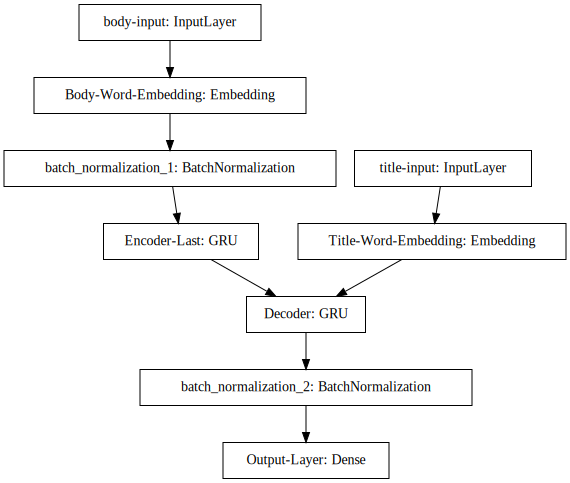

In [80]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Some Brief thoughts on how this model can improve from tuning the parameters

 I found a positive correlation b/w the following items and accuracy
 
 - The learning rate can be decreased.
 - The latent dimension should be increased.  Right now its 300 lets try 600
 - Right now only training on 1.4M rows of data.  I can scale this up to 10M rows really easily and that should dramatically improve accuracy.
 - I haven't gone through the process of making the model overfit and backing it off until it is "just right" this is a key step that I skipped because the model was "good enough" for MVP.  
 
 
 Other optimizations I should do:
 
 - Add Attention Layer
 - Stack RNNs instead of just having a single layer for both encoder and decoder. 
 - Better tokenization of text -> right now its very suboptimal.  Areas where I'm getting tokenization wrong.  Also not handling code gracefully.  

 
 Things I tried that didn't work initially but should try again:
 
 - Bi-directional RNN -> Added more capacity but didn't seem to increase accuracy.  I should try skip connection - Have a stack that reads the text forwards and backwards and concatenates that to the encoding vector.
 
 Things I haven't tried at all:
 
 - Pre-train word embeddings instead of learning them from scratch (My intution is this shouldn't work well for this problem.  

In [42]:
from keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'v2_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 10
history = model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.15, callbacks=[csv_logger, model_checkpoint])

Train on 1190000 samples, validate on 210000 samples
Epoch 1/10
1190000/1190000 [==============================] - 179s 150us/step - loss: 3.0874 - val_loss: 2.7067


/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer Decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Last/while/Exit_2:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.6040 - val_loss: 2.5945
Epoch 3/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.4991 - val_loss: 2.5555
Epoch 4/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.4393 - val_loss: 2.5351
Epoch 5/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.3972 - val_loss: 2.5254
Epoch 6/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.3648 - val_loss: 2.5240
Epoch 7/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.3378 - val_loss: 2.5233
Epoch 8/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.3153 - val_loss: 2.5275
Epoch 9/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.2955 - val_loss: 2.5304
Epoch 10/10
1190000/1190000 [==============================] - 176s 148us/step - loss: 2.2778 - val_loss

In [43]:
! ls -lah | grep v2_seq2seq

-rw-r--r--  1 root  root   61M Dec 15 01:21 v2_seq2seq.epoch01-val2.70675.hdf5
-rw-r--r--  1 root  root   61M Dec 15 01:24 v2_seq2seq.epoch02-val2.59445.hdf5
-rw-r--r--  1 root  root   61M Dec 15 01:27 v2_seq2seq.epoch03-val2.55547.hdf5
-rw-r--r--  1 root  root   61M Dec 15 01:30 v2_seq2seq.epoch04-val2.53507.hdf5
-rw-r--r--  1 root  root   61M Dec 15 01:33 v2_seq2seq.epoch05-val2.52536.hdf5
-rw-r--r--  1 root  root   61M Dec 15 01:36 v2_seq2seq.epoch06-val2.52396.hdf5
-rw-r--r--  1 root  root   61M Dec 15 01:39 v2_seq2seq.epoch07-val2.52329.hdf5
-rw-r--r--  1 root  root   326 Dec 15 01:47 v2_seq2seq.log


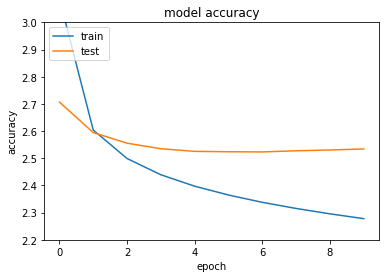

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_model_training_history(history_object):
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim([2.2, 3.0])
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_model_training_history(history)

Looks like it is overfitting - should add some regularization

In [50]:
######## Create Encoder, Simple
def extract_encoder_model():
    """This is really straight forward, just grab the correct input and output layer from original model
       For the encoder, there is only one input layer and one output layer, no looping or multiple inputs.
    """
    #TODO: clean this up once your are confident to take as input model object
    
    encoder_model = Model(encoder_inputs, state_h)
    return encoder_model

In [51]:
def extract_decoder_model():
    """
    Extract the decoder from the training network.  This is a little tricky so I made some notes in comments.
    """
    #TODO: clean this up once your are confident to take as input model object
    
    # Instead of setting the intial state from the encoder and forgetting about it, during inference
    # we are not doing teacher forcing, so we will have to have a feedback loop from predictions back into
    # the GRU, thus we define this input layer for the state so we can add this capability
    d_gru_inference_state_input = Input(shape=(latent_dim,))
    
    # we need to reuse the weights that is why we are getting this
    d_gru_inference = model.get_layer('Decoder')
    # If you inspect the decoder GRU that we created for training, it will take as input 
    # 2 tensors -> (1) is the embedding layer output for the teacher forcing 
    #                  (which will now be the last step's prediction, and will be _start_ on the first time step)
    #              (2) is the state, which we will initialize with the encoder on the first time step, but then
    #                   grab the state after the first prediction and feed that back in again.
    d_gru_out, d_gru_state_out = d_gru_inference([dec_emb, d_gru_inference_state_input])


    d_dense_out = decoder_dense(d_gru_out)
    d_model_inference = Model([decoder_inputs, d_gru_inference_state_input], 
                              [d_dense_out, d_gru_state_out])
    return d_model_inference

In [52]:
decoder_model_inference = extract_decoder_model()
decoder_model_inference.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title-input (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Title-Word-Embedding (Embedding (None, None, 300)    1200600     title-input[0][0]                
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
Decoder (GRU)                   [(None, None, 300),  540900      Title-Word-Embedding[0][0]       
                                                                 input_1[0][0]                    
__________

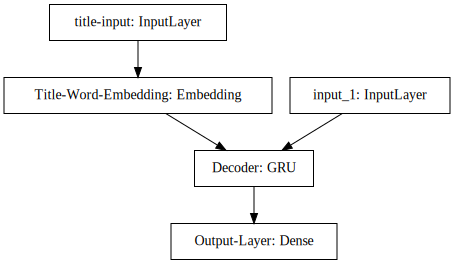

In [82]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(decoder_model_inference).create(prog='dot', format='svg'))

In [53]:
encoder_model_inference = extract_encoder_model()
encoder_model_inference.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
body-input (InputLayer)      (None, 60)                0         
_________________________________________________________________
Body-Word-Embedding (Embeddi (None, 60, 300)           1800600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 300)           1200      
_________________________________________________________________
Encoder-Last (GRU)           [(None, 300), (None, 300) 540900    
Total params: 2,342,700
Trainable params: 2,342,100
Non-trainable params: 600
_________________________________________________________________


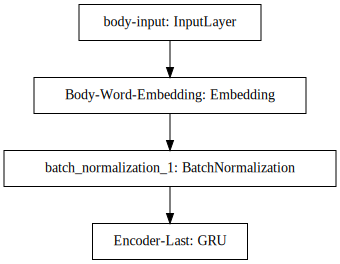

In [81]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(encoder_model_inference).create(prog='dot', format='svg'))

## Save The Encoder and Decoder Separately

In [54]:
decoder_model_inference.save('decoder_model_inference.h5')

/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer Decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_1:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [55]:
encoder_model_inference.save('encoder_model_inference.h5')

# Test If Serialized Models Work

In [57]:
from keras.models import load_model

In [58]:
encoder_model_loaded = load_model('encoder_model_inference.h5')

/opt/conda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [79]:
encoder_model_inference.predict(encoder_input_data[0:1]).shape

(1, 300)

In [59]:
decoder_model_loaded = load_model('decoder_model_inference.h5')

/opt/conda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [60]:
def generate_issue_title_vOriginal(raw_input_text, stochastic=False, max_len_title=12):
    # Seed For _start_ token
    raw_tokenized = ppm_body.transform_text([raw_input_text])
    body_encoding = encoder_model_inference.predict(raw_tokenized)
    state_value = np.array(title_token2id['_start_']).reshape(1, 1)

    decoded_sentence = []
    stop_condition = False
    while not stop_condition:
        preds, st = decoder_model_inference.predict([state_value, body_encoding])

        # This is cheating because we are going to ignore indices 0 (padding) and indices 1 (unknown)
        #  Argmax will return the integer index corresponding to the prediction + 2 b/c we chopped off first two
        pred_idx = np.argmax(preds[:,:,2:]) + 2

        if stochastic is True:
            normalized_probs = preds[0,0,2:] / np.sum(preds[0,0,2:])
            integer_idxs = np.arange(2, max(title_id2token.keys()) + 1)
            pred_idx = np.random.choice(integer_idxs, p = normalized_probs)
        
        # retrieve word from index prediction
        pred_word_str = title_id2token[pred_idx]

        

        if pred_word_str == '_end_' or len(decoded_sentence) >= max_len_title:
            stop_condition = True
            break
        decoded_sentence.append(pred_word_str)
        
        #update the decoder for the next word
        body_encoding = st
        state_value = np.array(pred_idx).reshape(1, 1)
        
    return ' '.join(decoded_sentence)

In [61]:
def generate_issue_title_vLoaded(raw_input_text, stochastic=False, max_len_title=12):
    # Seed For _start_ token
    raw_tokenized = ppm_body.transform_text([raw_input_text])
    body_encoding = encoder_model_loaded.predict(raw_tokenized)
    state_value = np.array(title_token2id['_start_']).reshape(1, 1)

    decoded_sentence = []
    stop_condition = False
    while not stop_condition:
        preds, st = decoder_model_loaded.predict([state_value, body_encoding])

        # This is cheating because we are going to ignore indices 0 (padding) and indices 1 (unknown)
        #  Argmax will return the integer index corresponding to the prediction + 2 b/c we chopped off first two
        pred_idx = np.argmax(preds[:,:,2:]) + 2

        if stochastic is True:
            normalized_probs = preds[0,0,2:] / np.sum(preds[0,0,2:])
            integer_idxs = np.arange(2, max(title_id2token.keys()) + 1)
            pred_idx = np.random.choice(integer_idxs, p = normalized_probs)
        
        # retrieve word from index prediction
        pred_word_str = title_id2token[pred_idx]

        

        if pred_word_str == '_end_' or len(decoded_sentence) >= max_len_title:
            stop_condition = True
            break
        decoded_sentence.append(pred_word_str)
        
        #update the decoder for the next word
        body_encoding = st
        state_value = np.array(pred_idx).reshape(1, 1)
        
    return ' '.join(decoded_sentence)

In [62]:
i = 910023
raw_input_text=data_to_clean_body[i]
raw_input_text

'hi everyone\n\ni am facing below issue where i am not able to perform save operation in configure section of code repo when i click on save button system does not respond and it stays as it is \n\nfrom other threads i found that api and collector needs to be run for this i have executed both of them and both of them are running properly\n\ncould you please help me here\n\ni have pasted my properties file below for your reference\n database name\n\nspringdatamongodbdatabasedashboarddb\n database hostname  de'

In [63]:
generate_issue_title_vOriginal(raw_input_text)

'unable to save pull request in save method in ui'

In [64]:
generate_issue_title_vLoaded(raw_input_text)

'unable to save pull request in save method in ui'

! Yes it works

## Make Inferencing Function

For now just taking this from above

In [66]:
generate_issue_title = generate_issue_title_vLoaded

# Show Examples  (This is The Best Part)

In [67]:
def show_examples_from_data(i):
    print(f'\n\n ======= Example # {i} ==========\n')
    raw_input_text=data_to_clean_body[i]

    print('Issue Body:\n', raw_input_text, '\n')

    print('Title:\n', data_to_clean_title[i])

    print('\n******Prediction*******:\n', generate_issue_title(raw_input_text))

In [68]:
demo_list = np.random.randint(low = 1, high =len(data_to_clean_body), size = 30)

In [69]:
for i in demo_list:
    show_examples_from_data(i)



 ======= Example # 492431 ==========

Issue Body:
 i need to add start up animation on pie chart and and could not find way to do this 

Title:
 animation on pie charts

******Prediction*******:
 how can i start pie chart on start and add new animation


 ======= Example # 620066 ==========

Issue Body:
 ive been using circ for a couple weeks since buying a chromebook and its a pretty client but theres a bunch of things that need fixing that ive seen and a stack of unanswered issues i dont really expect anyone else to pay attention to this ticket im just making a point in case anyone wants to show this project some love i might even be the person doing the work if this ticket gets closed then i guess someones paying attention anyway

so is this something that might happen eventually or should i  

Title:
 needs a solid week of dedication and polish

******Prediction*******:
 fixing issue with creating a new ticket that causes the client to


 ======= Example # 826608 ==========

Issu


******Prediction*******:
 spurious spurious update template includes old version of the new base branch


 ======= Example # 980081 ==========

Issue Body:
 we work with a lot of java and scala stacktraces and the other options ive tried for supporting them in heka dont work as well as id like this is an implementation of a regexbased multilinesplitter which works great for our stacktraces the implementation is that you define a regex to use as the delimiter and a regex used to match lines that should be joined together it first splits the buffer using the delimiter and then checks each section against the multiline regex to see if its a match all l 

Title:
 implementation of a multiline splitter

******Prediction*******:
 support for custom delimiter handling in the raw delimiter handling


 ======= Example # 615760 ==========

Issue Body:
 i wanted to display an error class on the invalid inputs only after the form was submitted but this doesnt seem to be possible just yet
also its

## Sandbox To Play With Input Text and Get Summary

In [72]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
@register_cell_magic
def summarize_issue(line, cell):
    answer = generate_issue_title(cell)
    print('\n******Prediction*******:\n',answer)

In [73]:
%%summarize_issue




******Prediction*******:
 add support for continuous scaling


# Appendix

## Test Fit Generator

In [257]:
import threading

class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g

In [90]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
import time


arr_data = np.random.randint(0, 256, (50000, 2))

arr_labels = np.random.randint(0, 2, 50000)

@threadsafe_generator
def custom_generator(use_weights=False):
        batch_size = 10
        n_samples = arr_data.shape[0]

        while True:
            batch_index = np.random.randint(0, n_samples - batch_size)
            start = batch_index
            end = start + batch_size
            X = arr_data[start: end]
            y = arr_labels[start: end]
            time.sleep(1) # simulate i/olag from disk
            yield X, y

# Build a NN
model = Sequential()
model.add(Dense(1, input_shape=(2, )))
model.compile(loss='mse', optimizer='adadelta')

In [92]:
%%time
# use normal threading
model.fit_generator(custom_generator(),
                    steps_per_epoch=10,
                    epochs=1,
                    verbose=1,
                    max_queue_size=10,
                    workers=8,
                    use_multiprocessing=False)

Epoch 1/1
10/10 [==============================] - 10s 1s/step - loss: 7718.3467
CPU times: user 304 ms, sys: 76 ms, total: 380 ms
Wall time: 18 s


In [93]:
%%time
# use process based threading, duplicates data
model.fit_generator(custom_generator(),
                    steps_per_epoch=10,
                    epochs=1,
                    verbose=1,
                    max_queue_size=10,
                    workers=8,
                    use_multiprocessing=True)

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2057: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
10/10 [==============================] - 1s 147ms/step - loss: 7118.5013
CPU times: user 100 ms, sys: 772 ms, total: 872 ms
Wall time: 2.2 s


In [95]:
%%time
#no parallelism
model.fit_generator(custom_generator(),
                    steps_per_epoch=10,
                    epochs=1,
                    verbose=1,
                    max_queue_size=1,
                    workers=1,
                    use_multiprocessing=False)

Epoch 1/1
10/10 [==============================] - 10s 1s/step - loss: 6720.5703
CPU times: user 204 ms, sys: 48 ms, total: 252 ms
Wall time: 10.1 s


In [96]:
arr_data = np.array([range(500)]).T
arr_labels = arr_data

In [271]:
from keras.models import Model
from keras.layers import Input, Dense
from time import sleep
import bcolz
lock = threading.Lock()

a = Input(shape=(1,))
model = Model(inputs=a, outputs=a)
model.compile(loss='mse', optimizer='adadelta')

start = 0

@threadsafe_generator
def custom_generator(use_weights=False):
        batch_size = 10
        n_samples = arr_data.shape[0]

        while True:
            batch_index = 1
            start = batch_index
            end = start + batch_size
            X = arr_data[start: end]
            y = arr_labels[start: end]
            time.sleep(.01) # simulate i/olag from disk
            yield X, y

In [272]:
%%time
test1 = model.predict_generator(custom_generator(), steps = 100, workers=2, 
                               use_multiprocessing=False)

CPU times: user 156 ms, sys: 32 ms, total: 188 ms
Wall time: 1.04 s


In [266]:
%%time
test2 = model.predict_generator(custom_generator(), steps = 100, 
                               workers=1, use_multiprocessing=False)

CPU times: user 76 ms, sys: 20 ms, total: 96 ms
Wall time: 1.03 s


In [243]:
from keras.utils import Sequence

In [244]:
import math
class Custom_Seq(Sequence):

    def __init__(self, x_set=arr_data, y_set=arr_labels, batch_size=10):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        time.sleep(.1)
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x, batch_y

In [245]:
cs = Custom_Seq()

In [246]:
%%time
test3 = model.predict_generator(cs, steps=100, workers=10, use_multiprocessing=True)

CPU times: user 0 ns, sys: 2.97 s, total: 2.97 s
Wall time: 3.8 s


# Appendix

### Benchmark Single vs. Parallel Threads

In [42]:
benchmark_n = 500000
from multiprocessing import cpu_count
n_cores = cpu_count()
print(f'benchmarking {benchmark_n:,} rows on {n_cores} cores.')

benchmarking 500,000 rows on 8 cores.


**Single Threaded Version**

In [43]:
%%time
results_single = ppm.process_text(data_to_clean[:benchmark_n])

CPU times: user 41.9 s, sys: 536 ms, total: 42.4 s
Wall time: 42.4 s


In [44]:
[x[:6] for x in results_single[:3]]

[['the', 'getlog', 'methods', 'on', 'services', 'are'],
 ['done', 'the', 'migration', 'from', 'hepmcgenparticle', 'to'],
 ['here', 'is', 'my', 'template', 'code', 'for']]

**Multi-Threaded Version**

In [45]:
%%time
results_parallel = ppm.parallel_process_text(data_to_clean[:benchmark_n])

CPU times: user 1.92 s, sys: 936 ms, total: 2.86 s
Wall time: 22.8 s


In [46]:
[x[:6] for x in results_parallel[0][:3]]

[['the', 'getlog', 'methods', 'on', 'services', 'are'],
 ['done', 'the', 'migration', 'from', 'hepmcgenparticle', 'to'],
 ['here', 'is', 'my', 'template', 'code', 'for']]

## How To Instantiate A Magic Function for Jupyter Cells

In [3]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
@register_cell_magic
def sql(line, cell):
    return presto2df(cell)

In [4]:
%%sql

select * from hive.entities.repos limit 10

,owner_id,owner_type,repo_id,name,repo_nwo,description,homepage,repo_created_at,primary_language_id,is_fork,num_public_forks,is_public,has_wiki,open_source_license,num_stars,num_issues,num_prs,issue_authors,pr_authors,merged_pr_authors,num_issue_authors,num_pr_authors,num_merged_pr_authors,first_issue_created_at,first_pr_created_at,last_issue_created_at,last_pr_created_at,last_pr_merged_at,num_fetches_last_30_days,fetchers_last_30_days,num_fetchers_last_30_days,first_push_at,last_push_at,num_pushes_last_30_days,num_commits_last_30_days,committers_last_30_days,num_committers_last_30_days,num_views_last_30_days,logged_in_viewers_last_30_days,num_logged_in_viewers_last_30_days,pct_threads_with_assignee,num_protected_branches,protected_branch_names
0,13621688,User,40116050,2,blogers/2,None,None,2015-08-03,192.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,2015-08-03 02:18:48.000,2015-08-03 02:18:48.000,0.0,None,None,None,NaN,None,NaN,None,None,None
1,13621688,User,40116027,194,blogers/194,None,None,2015-08-03,192.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,2015-08-03 02:18:18.000,2015-08-03 02:18:18.000,0.0,None,None,None,NaN,None,NaN,None,None,None
2,13621688,User,40115960,180,blogers/180,None,None,2015-08-03,192.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,[12613545],1.0,2015-08-03 02:17:01.000,2015-08-03 02:17:01.000,0.0,None,None,None,NaN,None,NaN,None,None,None
3,13621688,User,40115892,171,blogers/171,None,None,2015-08-03,192.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,2015-08-03 02:16:10.000,2015-08-03 02:16:10.000,0.0,None,None,None,NaN,None,NaN,None,None,None
4,13621688,User,40115825,160,blogers/160,None,None,2015-08-03,192.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,2015-08-03 02:15:10.000,2015-08-03 02:15:10.000,0.0,None,None,None,NaN,None,NaN,None,None,None
5,13621688,User,40115712,134,blogers/134,None,None,2015-08-03,192.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,[12613545],1.0,2015-08-03 02:12:42.000,2015-08-03 02:12:42.000,0.0,None,None,None,NaN,None,NaN,None,None,None
6,13621688,User,40115622,12,blogers/12,None,None,2015-08-03,192.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,[12613545],1.0,2015-08-03 02:11:22.000,2015-08-03 02:11:22.000,0.0,None,None,None,NaN,None,NaN,None,None,None
7,13621688,User,40115577,110,blogers/110,None,None,2015-08-03,NaN,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2.0,[12613545],1.0,2015-08-03 02:10:33.000,2015-08-03 02:10:33.000,0.0,None,None,None,NaN,None,NaN,None,None,None
8,13622183,User,86450634,liaokongvfx.github.io,liaokongVFX/liaokongvfx.github.io,None,None,2017-03-28,140.0,False,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,[None],1.0,2017-03-28 04:12:57.000,2017-03-28 04:14:10.000,0.0,None,None,None,8.0,"[None, 34088524]",2.0,None,None,None
9,13622329,User,107088488,thundercracker,fishbaoz/thundercracker,"b""The software toolchain for Sifteo's 2nd gene...",None,2017-10-15,149.0,True,0,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,NaN,None,None,None,1.0,[32748793],1.0,None,None,None


# Try Dask

In [5]:
import dask.dataframe as dd
from time import sleep
dask_df = dd.from_pandas(data=df, chunksize=10000)
dask_df = dask_df.repartition(npartitions=8)
dask_df.head()

,repo_name,repo_id,repo_homepage,issue_id,issue_number,body,issue_title,issue_title_len,body_len
0,codeformatter,28896487,,68794631,112,some checks that we will soon implement are ra...,add a switch to optout of slow checks,8,45
1,SalesforceMobileSDK-iOS,2338086,https://github.com/forcedotcom/SalesforceMobil...,68794668,992,this fixes the issues we were seeing in ios a...,taking the broken completion block hack out of...,9,14
2,KOS,17217530,None,68794714,831,since its not possible to tell the current sta...,enhancement a state field in the core right cl...,10,74
3,CMS,9184554,http://www.kooboo.com,17981461,122,for examplesome one login in httpwwwkooboocomc...,oauth login not work correctly in a site with ...,12,26
4,ipython,658518,https://ipython.readthedocs.org,17981488,4005,according to the documentation it should launc...,ipythonstart_kernel doesnt work,3,125


In [6]:
from DeepText.preprocess import preProcessor
pp = preProcessor()
clean_func = pp.default_cleaner
tokenizer = pp.default_tokenizer

## Basic Check to see if dask is actually working

In [11]:
%%time
dask_df.body.apply(lambda x: sleep(.0001)).head()

/opt/conda/lib/python3.6/site-packages/dask/dataframe/core.py:1979: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


CPU times: user 76 ms, sys: 16 ms, total: 92 ms
Wall time: 1.38 s


0    None
1    None
2    None
3    None
4    None
Name: body, dtype: object

In [12]:
%%time
df.body.apply(lambda x: sleep(.0001)).head()

CPU times: user 544 ms, sys: 132 ms, total: 676 ms
Wall time: 10.9 s


0    None
1    None
2    None
3    None
4    None
Name: body, dtype: object

In [7]:
%%time
dask_df['new_col'] = dask_df.body.apply(clean_func)
dask_df['token_body'] = dask_df.new_col.apply(tokenizer)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.81 ms


/opt/conda/lib/python3.6/site-packages/dask/dataframe/core.py:1979: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [8]:
%%time
dask_df.token_body.loc[125:155].compute()

CPU times: user 1min 11s, sys: 12 ms, total: 1min 11s
Wall time: 1min 11s


125    [hi, there, \n , thanks, again, for, making, t...
126    [hi, \n, considering, mock, objects, which, ar...
127    [see, the, thread, starting, here, \n, httplis...
128    [phoenix, httpphoenixapacheorg, is, an, open, ...
129    [pr, for, issue, httpsgithubcomflywayflywayiss...
130    [i, do, nt, believe, nslookup, on, its, own, w...
131    [this, change, was, added, in, then, removed, ...
132    [if, a, stream, output, is, missing, text, log...
133    [previously, the, geoip, plugin, would, crash,...
134    [since, it, shows, regular, tracebacks, now, r...
135    [we, would, like, to, be, able, to, retrieve, ...
136    [httpsgithubcomjamesmartininline_svg, \n, i, m...
137    [i, have, just, install, the, parsimony, cms, ...
138    [odoo, have, bug, with, webclient, view, on, c...
139    [i, would, like, to, access, the, machinename,...
140    [solution, \n , add, it, to, makefileam, \n, n...
141    [explain, the, issue, \n, the, alignment, of, ...
142    [hello, wave, \n, rocket